In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner

In [2]:
import xoflares #  the flares code

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.2.2
1.0.4
3.7


In [4]:
#  let's create some take data
#  we simulate 10 flares. In reality the flares enengies are distributed like a power law,
#  but that's not easy to draw from here, so we'll make the amplitudes follow a power law.
#  Inside the model, we learn the shape of the power law, in the real stars example, we want to
#  learn that function of ED, not amplitude.
t = np.arange(0,15,2/1440)
tpeaks = np.random.choice(t, size=20)
fwhms = np.random.uniform(size=20, low=6/1440, high=0.1)
ampls = np.random.pareto(a=1.8, size=20)
npeaks = np.shape(tpeaks)[0]

In [5]:
y = xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls)
yerr = 0.2 * np.ones_like(y)
y +=  np.random.normal(scale=yerr, size=np.shape(t)[0])
x = t

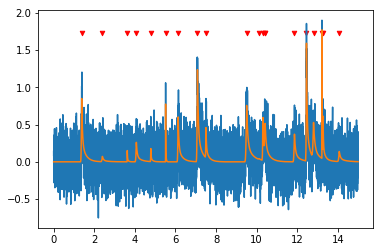

In [6]:
plt.plot(t, y)
plt.plot(t, xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls))
plt.scatter(tpeaks, np.zeros_like(tpeaks) + np.max(ampls), color='r', s=20, marker='v')

In [7]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:
        
        xval = pm.Data('xval', x[mask])
        data = pm.Data('data', y[mask])
        data_err = pm.Data('data_err', yerr[mask])
        tpeaks_d = pm.Data('tpeaks_d', tpeaks)
        fwhms_d = pm.Data('fwhms_d', fwhms)
        ampls_d = pm.Data('ampls_d', ampls)

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=2.0)

        BoundedNormal = pm.Bound(pm.Normal, lower=0)
        tpeak = BoundedNormal("tpeak", mu=tpeaks_d, sd=0.01,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=tt.log(fwhms_d), sd=0.5, testval=tt.log(fwhms_d),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=tt.log(ampls_d), sd=0.5, testval=tt.log(ampls_d),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(xval, tpeak, fwhm, ampl, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve
        
        ED_days = xoflares.multiflareintegral(fwhm, ampl)
        pm.Deterministic("ED_days", ED_days)

        pm.Normal('obs', mu=light_curve + mean, sd=data_err, observed=data)

#        prior on the flare energies, loglike of pareto dist
        alpha = BoundedNormal('alpha', mu=1.8, sd=0.2)
        m=1
        pm.Potential('ampls_hyper',( npeaks*np.log(alpha)) +
                     (npeaks*alpha*np.log(m)) -
                     (alpha+1)*tt.sum(ampl))
    
        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])

        map_soln = xo.optimize(start=map_soln, vars=[mean])

        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [mean]
5it [00:00,  6.23it/s, logp=2.166379e+03]  
message: Optimization terminated successfully.
logp: 2161.5909854724086 -> 2166.378701106568
optimizing logp for variables: [mean, logFwhm]
95it [00:00, 117.79it/s, logp=2.175889e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 2166.378701106568 -> 2175.888769042086
optimizing logp for variables: [mean, logAmpl]
41it [00:00, 72.25it/s, logp=2.179165e+03] 
message: Optimization terminated successfully.
logp: 2175.888769042086 -> 2179.1652397515745
optimizing logp for variables: [logAmpl, logFwhm]
101it [00:01, 94.61it/s, logp=2.181955e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 2179.1652397515745 -> 2181.95443956393
optimizing logp for variables: [tpeak]
110it [00:00, 119.23it/s, logp=2.187300e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 2181.95443956393 -> 2187.3139162156735
optimizing logp for var

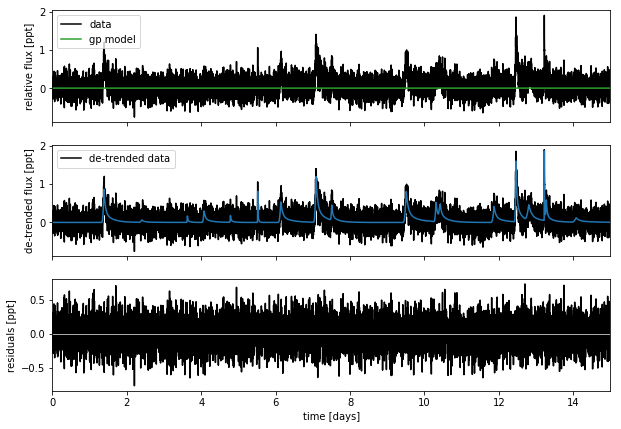

In [8]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = np.ones_like(x[mask]) * soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

optimizing logp for variables: [mean]
5it [00:00, 12.98it/s, logp=2.187902e+03]  
message: Optimization terminated successfully.
logp: 2187.9015742321403 -> 2187.901675419371
optimizing logp for variables: [mean, logFwhm]
60it [00:00, 89.38it/s, logp=2.187915e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 2187.901675419371 -> 2187.901675419371
optimizing logp for variables: [mean, logAmpl]
42it [00:00, 204.88it/s, logp=2.187929e+03]
message: Optimization terminated successfully.
logp: 2187.901675419371 -> 2187.9289925507906
optimizing logp for variables: [logAmpl, logFwhm]
77it [00:00, 81.31it/s, logp=2.187930e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 2187.9289925507906 -> 2187.9289925507906
optimizing logp for variables: [tpeak]
79it [00:00, 103.79it/s, logp=2.164727e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 2187.9289925507906 -> 2187.9289925507906
optimizing logp for 

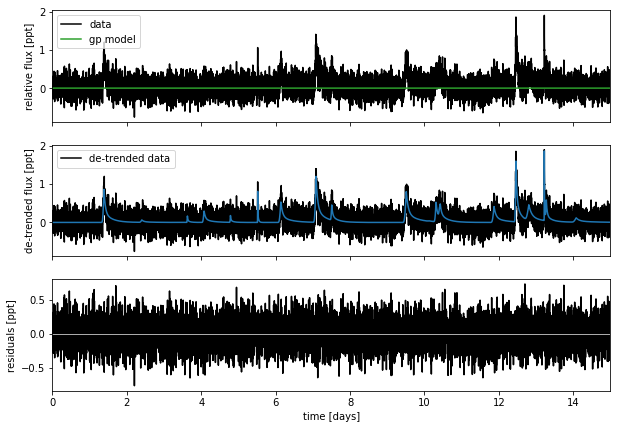

In [9]:
model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [10]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

optimizing logp for variables: [alpha, logAmpl, logFwhm, tpeak, mean]
79it [00:00, 81.64it/s, logp=2.164734e+03]  
message: Desired error not necessarily achieved due to precision loss.
logp: 2187.9289925507906 -> 2187.9289925507906


In [ ]:
with model:
    db = pm.backends.Text('test')
    pm.sample(tune=3000, draws=3000, start=map_soln2, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9, doubling=False, adaptation_window=151),
                     trace=db)

# with model:
#     mean_field = pm.fit(method='advi', start=map_soln2,  n=100000,
#                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, logAmpl, logFwhm, tpeak, mean]
Sampling 4 chains:  44%|████▍     | 10603/24000 [53:42<180:46:11, 48.58s/draws]

In [ ]:
# with model:
#     trace = mean_field.sample(3000)
plt.plot(trace.get_values('alpha', chains=[2]))

(array([6.000e+00, 3.000e+01, 9.000e+01, 2.110e+02, 4.650e+02, 8.730e+02,
        1.264e+03, 1.728e+03, 1.855e+03, 1.729e+03, 1.481e+03, 1.082e+03,
        6.240e+02, 3.420e+02, 1.440e+02, 5.500e+01, 1.400e+01, 6.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.91027923, 0.98382902, 1.05737881, 1.1309286 , 1.2044784 ,
        1.27802819, 1.35157798, 1.42512777, 1.49867757, 1.57222736,
        1.64577715, 1.71932694, 1.79287674, 1.86642653, 1.93997632,
        2.01352611, 2.0870759 , 2.1606257 , 2.23417549, 2.30772528,
        2.38127507]),
 <a list of 1 Patch objects>)

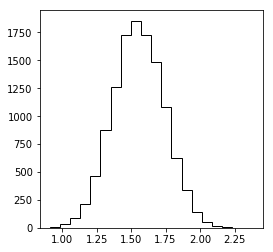

In [40]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['alpha'], bins=20, histtype='step', color="k")



In [35]:
print(fwhms)
print(tpeaks)

[0.08906266 0.00906299 0.01983627 0.01880084 0.05301767 0.06302369
 0.03060258 0.09222275 0.09552492 0.05127932]
[13.55972222  0.94861111  1.93194444  2.54583333  0.02638889  6.40416667
  1.84861111  3.66111111  9.12777778  7.34722222]


In [36]:
pm.summary(trace, var_names=['mean', 'alpha', 'tpeak', 'fwhm', 'ampl'])

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd      mc_error    hpd_2.5   hpd_97.5  \
tpeak__0  13.559475  0.001325  9.445644e-06  13.556768  13.562053   
tpeak__1   0.949717  0.008948  7.646003e-05   0.931756   0.968323   
tpeak__2   1.931901  0.000097  8.089201e-07   1.931707   1.932087   
tpeak__3   2.540436  0.004199  6.395736e-05   2.531500   2.548416   
tpeak__4   0.030090  0.005181  6.105355e-05   0.019832   0.040814   
tpeak__5   6.401732  0.001466  1.204378e-05   6.398913   6.404597   
tpeak__6   1.846878  0.008491  6.665252e-05   1.831156   1.864192   
tpeak__7   3.659417  0.001192  9.737693e-06   3.657125   3.661754   
tpeak__8   9.126332  0.004870  4.506545e-05   9.117134   9.135968   
tpeak__9   7.350867  0.009952  7.946789e-05   7.331888   7.370908   
fwhm__0    0.087466  0.005557  4.065258e-05   0.077005   0.098517   
fwhm__1    0.009554  0.004888  4.159342e-05   0.002455   0.019178   
fwhm__2    0.020028  0.000376  2.963472e-06   0.019264   0.020733   
fwhm__3    0.018951  0.008218  7.398540e-05   0.006210   0.035451   
fwhm__4    0.072756  0.024457  2.098014e-04   0.031868   0.121701   
fwhm__5    0.073793  0.005468  4.157704e-05   0.063363   0.084719   
fwhm__6    0.037252  0.017481  1.523488e-04   0.010374   0.072151   
fwhm__7    0.092967  0.004178  3.384764e-05   0.084817   0.101051   
fwhm__8    0.114563  0.018645  1.242947e-04   0.082049   0.154450   
fwhm__9    0.060878  0.030701  2.952081e-04   0.015096   0.120651   
ampl__0    1.077527  0.044895  3.383998e-04   0.993289   1.169022   
ampl__1    0.049898  0.023904  2.393881e-04   0.012276   0.096000   
ampl__2    7.945498  0.096305  7.211935e-04   7.753534   8.127773   
ampl__3    0.213130  0.069107  6.392612e-04   0.088185   0.347835   
ampl__4    0.214260  0.044399  3.709355e-04   0.131666   0.304774   
ampl__5    1.050592  0.050258  3.590547e-04   0.951423   1.147136   
ampl__6    0.113972  0.038052  3.190903e-04   0.044940   0.188867   
ampl__7    1.542505  0.044279  3.452246e-04   1.456683   1.632760   
ampl__8    0.361204  0.037560  3.014882e-04   0.288223   0.433933   
ampl__9    0.048149  0.020680  1.881014e-04   0.014681   0.088667   

                 n_eff      Rhat  
tpeak__0  17132.076365  0.999907  
tpeak__1  12509.800660  1.000017  
tpeak__2  14404.528858  0.999957  
tpeak__3   4180.200814  0.999875  
tpeak__4   7880.029907  0.999900  
tpeak__5  13952.470235  1.000005  
tpeak__6  14311.642903  1.000020  
tpeak__7  16313.972170  0.999841  
tpeak__8  14112.442711  0.999853  
tpeak__9  16116.126243  0.999994  
fwhm__0   14191.720790  1.000082  
fwhm__1   15318.968077  1.000108  
fwhm__2   15165.263773  1.000250  
fwhm__3   12093.604556  0.999975  
fwhm__4   13075.886147  0.999892  
fwhm__5   16915.516270  0.999849  
fwhm__6   14045.938032  0.999863  
fwhm__7   15195.130357  0.999853  
fwhm__8   15770.825669  0.999945  
fwhm__9   12595.949137  1.000215  
ampl__0   16233.480380  0.999967  
ampl__1   12487.138786  1.000060  
ampl__2   16235.924347  1.000133  
ampl__3   11455.177752  1.000155  
ampl__4   15373.212009  0.999938  
ampl__5   16291.881365  0.999885  
ampl__6   14019.845622  0.999975  
ampl__7   16092.418336  0.999915  
ampl__8   14063.013317  0.999932  
ampl__9   14370.209085  0.999919

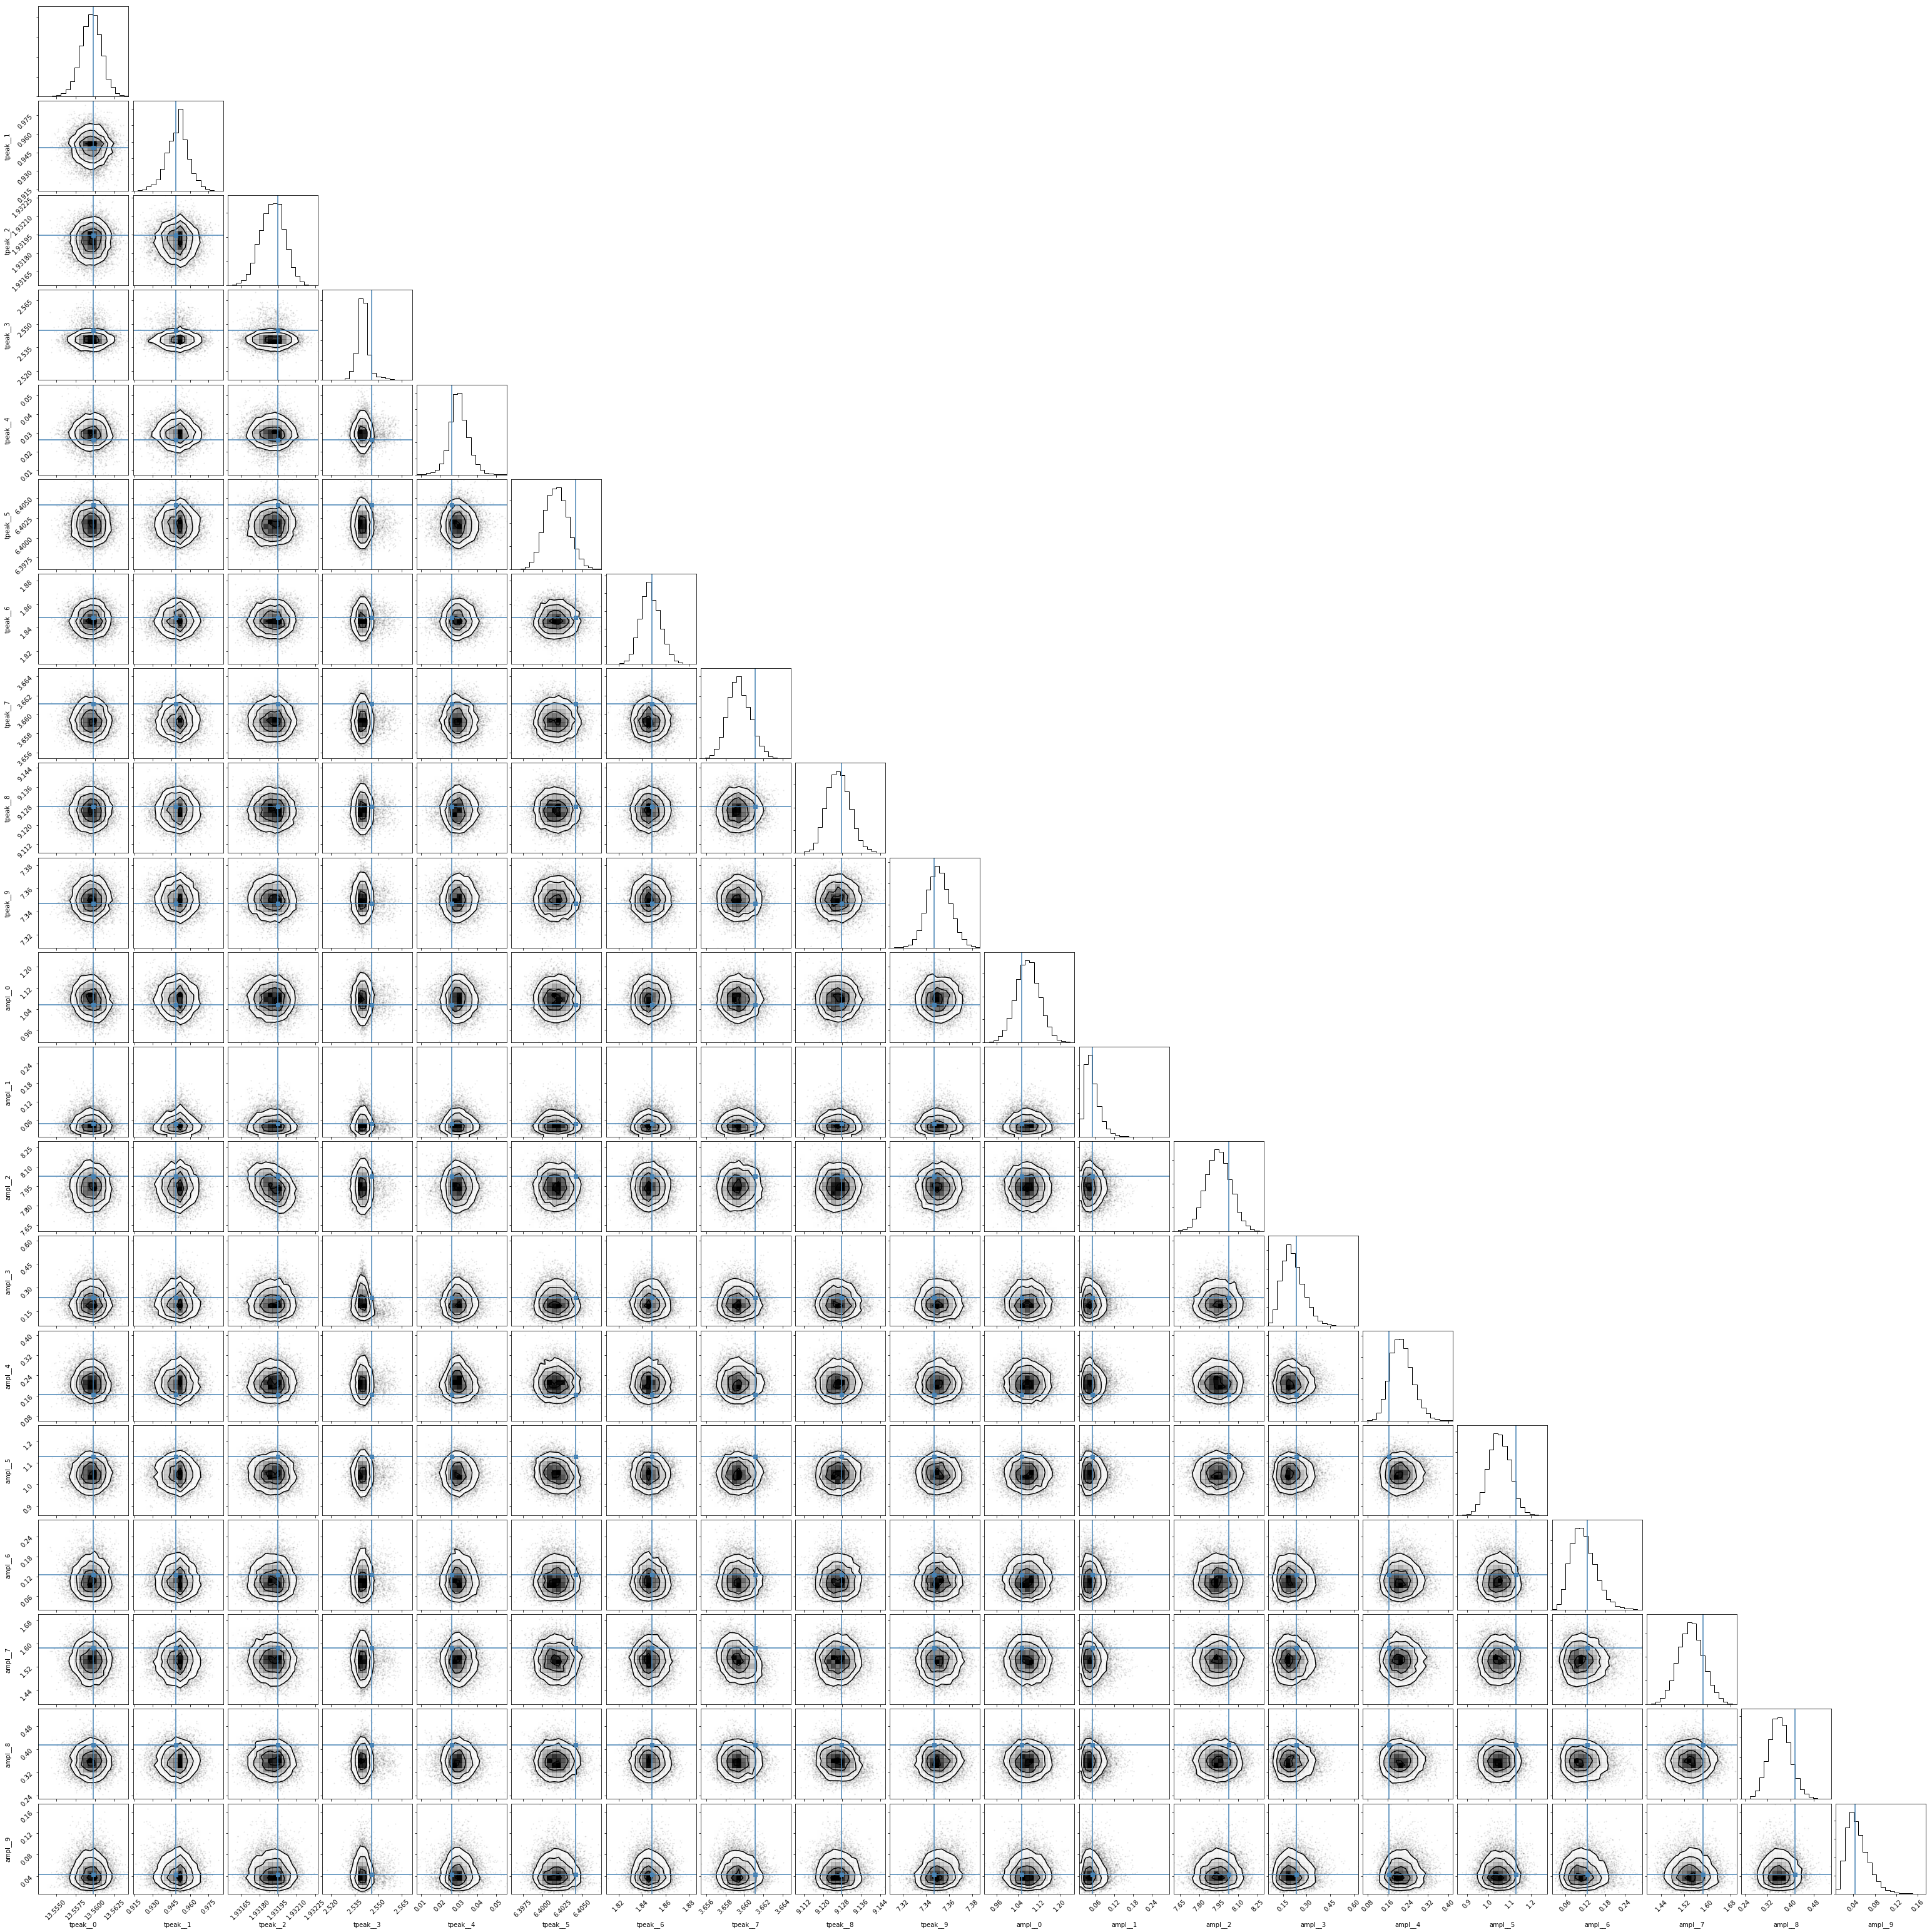

In [37]:
varnames = ["tpeak", 'ampl']
samples = pm.trace_to_dataframe(trace, varnames=varnames, )

corner.corner(samples, truths=np.array([tpeaks, ampls]).flatten());

In [39]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, 1 + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    
fig.tight_layout()

KeyError: 'Unknown variable light_curve'